In [2]:
%matplotlib inline

In [3]:
import os, sys

In [21]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
from fbprophet.plot import add_changepoints_to_plot
from datetime import timedelta

In [6]:
import requests

POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

"""
https://poloniex.com/public?command=returnChartData&currencyPair=BTC_POT&start=1435699200&end=9999999999&period=14400

"""

def get_ohlcv_poloniex(pair='BTC_ETH', start=1435699200, end=9999999999, period=900):
    """
    returns ohlcv data for poloniex as pandas dataframe
    convert to unix timestamp using https://coderstoolbox.net/unixtimestamp/
    :param pair: str pair on poloniex
    :param start: int unix timestamp of beginning time
    :param end: int unix timestamp of ending time
    :param period: int candle width in seconds
    :return: pandas df of ohlcv data from poloniex for specified pair, times, and period
    """
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query,verify=False)

    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))

    return pd.DataFrame(resp.json())

In [11]:
df = get_ohlcv_poloniex(pair='USDT_BTC', start=1483600958, end=9999999999, period=900)
#no option to pass in 3600 sec candles
df = df[df.index % 4 == 0]
df['ds'] = pd.to_datetime(df['date'], unit='s')
df['y'] = df['weightedAverage']
df['logVolume'] = df['volume'].apply(np.log)

/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [17]:
df.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage,ds,y,logVolume
0,1143.999999,1483601400,1145.000000,1135.0000,1137.02,9.170638,10475.203351,1142.254643,2017-01-05 07:30:00,1142.254643,9.256766
4,1136.000000,1483605000,1136.000000,1124.0180,1124.50,23.515077,26504.327610,1127.120601,2017-01-05 08:30:00,1127.120601,10.185063
8,1092.000000,1483608600,1099.232465,1055.2912,1085.00,229.543299,247051.025497,1076.271998,2017-01-05 09:30:00,1076.271998,12.417350
12,1086.000000,1483612200,1111.000000,1085.0000,1096.00,72.148022,79375.560627,1100.176535,2017-01-05 10:30:00,1100.176535,11.281946
16,1099.593509,1483615800,1100.000000,1087.0000,1087.00,20.601704,22609.130935,1097.439857,2017-01-05 11:30:00,1097.439857,10.026109


In [8]:
class StructuralBreakFeatures:
    DEFAULT_FEATURES_TO_CALCULATE = []
    DROP_COLUMNS = ['open', 'high', 'low']

    def __init__(self,
                 features_to_calculate=None,
                 interval_size: timedelta=timedelta(days=1),
                 drop_columns=None):
        if features_to_calculate is None:
            features_to_calculate = self.DEFAULT_FEATURES_TO_CALCULATE

        if drop_columns is None:
            drop_columns = self.DROP_COLUMNS

        # Create feature generator and compute features
        self.interval_type = 'time'
        self.interval_size = interval_size
        self.features_to_calculate = features_to_calculate
        self.drop_columns = drop_columns

    def get_feature_data(self, data_df):
        """ Compute all features.
        :param data_df:
        :return:
        """
        feature_generator = FeatureGenerator(self.interval_type,
                                             self.interval_size,
                                             self.features_to_calculate)
        data_df_enriched = feature_generator.process_bulk_ticks(data_df)
        data_df_enriched = data_df_enriched.drop(self.DROP_COLUMNS, axis=1)

        return data_df_enriched

In [24]:
sadf_features = StructuralBreakFeatures([
    ('sadf_test', 2),     # 128 day lookback SADF
    ('sadf_test', 4),     # 128 day lookback SADF
    ('sadf_test', 8),     # 128 day lookback SADF
    ('sadf_test', 16),     # 128 day lookback SADF
    ('sadf_test', 32),     # 128 day lookback SADF
    ('sadf_test', 64),     # 128 day lookback SADF
    ('sadf_test', 128),     # 128 day lookback SADF
    ('sadf_test', 256),     # 256 day lookback SADF
    ('sadf_test', 512),     # 512 day lookback SADF
    ('sadf_test', 1024),     # 512 day lookback SADF
])

In [19]:
sadf_enriched = sadf_features.get_feature_data(df)
print(sadf_enriched.tail(2))

NameError: name 'FeatureGenerator' is not defined

In [ ]:
#I do not have the code for the Feature Generator so there is an error and the code is unable to run.

NameError: name 'sadf_enriched' is not defined

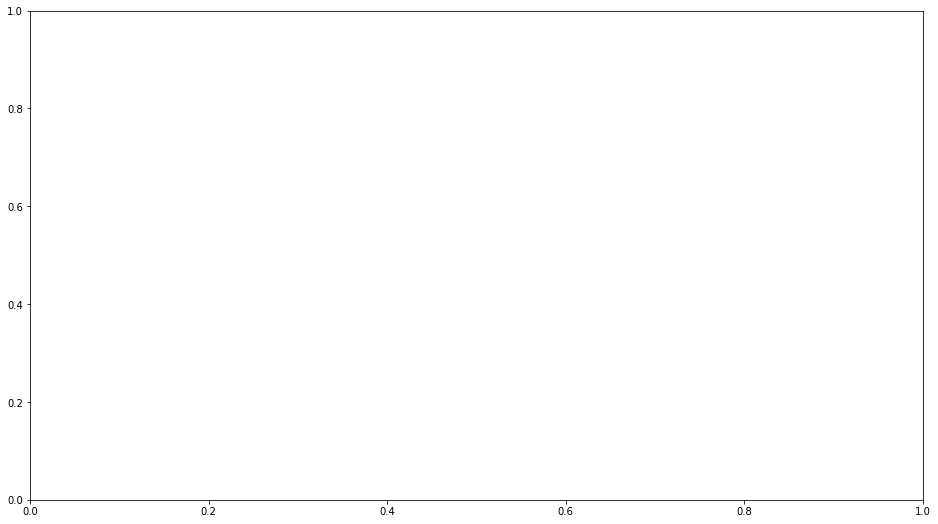

In [25]:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched['2_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched['4_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched['8_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched['16_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched['32_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched['64_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched['128_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched['256_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched['512_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sadf_enriched['close'].plot(ax=ax, style='b-', legend=True)
sadf_enriched['1024_sadf_test'].plot(ax=ax, style='ro', secondary_y=True, legend=True)